**ABSTRACT** : To perform fine tuning of the mobilenet model by using Imagenet pretrained model and fine tune it further to analyze the training, testing and validation set accuracy.

**TRANSFER** **LEARNING** **WITH** **MOBILENET** **MODEL**

**Q**. What is transfer learning?

**Ans**. Transfer of learning occurs when people apply information, strategies, and skills they have learned to a new situation or context. Transfer is not a discrete activity, but is rather an integral part of the learning process. Researchers attempt to identify when and how transfer occurs and to offer strategies to improve transfer.

**Q** Why do we do transfer learning?

**Ans**. Transfer learning has immense potential and is a commonly required enhancement for existing learning algorithms.

**Q** What is MobileNet model?

**Ans** The MobileNet model is designed to be used in mobile applications, and it is TensorFlow’s first mobile computer vision model.

**Q** Why did I choose MobileNet as my model?

Ans Since MobileNet uses depthwise separable convolutions. This results in lightweight deep neural networks. 

- A depthwise separable convolution is made from two operations.

- As well as the computation speed of a MobileNet model is faster as compared to other pretrained models.

**Loading** **all** **the** **important** **libraries**

In [1]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K


In [2]:
X_train = np.load("/content/drive/My Drive/256_192_train (1).npy")

**Checking** **the** **shape** **of** **X_train**

In [3]:
 X_train.shape

(8111, 192, 256, 3)

**NOTE** : Since the X_train is an image of the size 192x256x3, the shape of X_train comes out as a 4D array.

In [4]:
y_train = np.load("/content/drive/My Drive/train_labels.npy")

In [5]:
X_val = np.load("/content/drive/My Drive/256_192_val (1).npy")

In [6]:
y_val = np.load("/content/drive/My Drive/val_labels.npy")

In [8]:
X_train.shape, X_val.shape

((8111, 192, 256, 3), (902, 192, 256, 3))

Similarly, that is the same case with X_val as well.

In [9]:
y_train.shape, y_val.shape

((8111,), (902,))

**NOTE** : Since the y_train and y_val are just column values and we have 7 different classes in the dataset, it is extremely important to change them into categorical values.

In [10]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [11]:
y_train.shape, y_val.shape

((8111, 7), (902, 7))

**LOADING** **THE** **ARCHITECTURE** **OF** **MOBILENET** **TO** **PERFORM** **TRANSFER** **LEARNING** **USING** **IMAGENET** **DATA**

In [12]:
base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

**NOTE** : From the above command, one can say that the input to the mobilenet model's pretrained model is imagenet which is passed as weights to the MobileNet model. 

**Printing** **all** **the** **layers** **present** **in** **the** **base_model**

In [1]:
for layer in base_model.layers:
    print(layer.name)
    if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
        layer.trainable = True
        K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
        K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
    else:
        layer.trainable = False

print(len(base_model.layers))

NameError: ignored

One can see that there are a total of 87 rows/layers with "conv_pw_13_relu" being the last row of the stack.

In [14]:
last_layer = base_model.get_layer('conv_pw_13_relu')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, None, None, 1024)


### **MODEL** DEFINITION

In [16]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(7,activation='softmax')(x) #final layer with softmax activation


In [17]:
model=Model(inputs=base_model.input,outputs=preds)
#specify the inputs
#specify the outputs
#now a model has been created based on our architecture

In [22]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)   

**NOTE** : The above model summary shows the addition of the 5 layers that I have introduced in the new model over which our data will get trained in the future.

From the summary, one can see that the total number of parameters is equal to 5,856,455 out of which the trainable features are 5820551 and the non trainable features are 35904.

In [18]:
 for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

### **Feature** **Extraction**

In [19]:
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

**MODEL** **COMPILATION**

In [20]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

**TRAINING** **THE** **MODEL**

Here I'm considering the batch_size and epochs as 32 and 10 respectively.

In [21]:
batch_size = 32
epochs = 10
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size), 
                              validation_steps=(X_val.shape[0] // batch_size))


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
253/253 [==============================] - 1189s 5s/step - loss: 0.9710 - accuracy: 0.6691 - val_loss: 1.3405 - val_accuracy: 0.5759
Epoch 2/10
253/253 [==============================] - 1196s 5s/step - loss: 0.8801 - accuracy: 0.6815 - val_loss: 1.0947 - val_accuracy: 0.6629
Epoch 3/10
253/253 [==============================] - 1208s 5s/step - loss: 0.8512 - accuracy: 0.6901 - val_loss: 0.9311 - val_accuracy: 0.6708
Epoch 4/10
253/253 [==============================] - 1195s 5s/step - loss: 0.8256 - accuracy: 0.6948 - val_loss: 0.9775 - val_accuracy: 0.6507
Epoch 5/10
253/253 [==============================] - 1174s 5s/step - loss: 0.7961 - accuracy: 0.7096 - val_loss: 0.9255 - val_accuracy: 0.6283
Epoch 6/10
253/253 [==============================] - 1169s 5s/step - loss: 0.7754 - accuracy: 0.7210 - val_loss: 1.3368 - val_accuracy: 0.6975
Epoch 7/10
253/253 [==============================] - 1167s 

**NOTE** : One can see from the above training epochs that the model achieved a maximum training accuracy of 73.65% at an epoch value of 10, hence one can say that the model is performing well but it can be improved by fine tuning the model accuracy further.

**FINE** **TUNING** **THE** **MODEL**

In order to fine tune the model, we will consider a single layer of the model and try to predict the results on the testing and validation inputs. Here I'm considering layer 81 to fine tune my model further.

NOTE : WHEN ONLY A SINGLE LAYER OF THE MODEL IS CONSIDERED, THEN THE NUMBER OF EPOCHS CAN BE CALCULATED AS "NUMBER OF PRETRAINED MODEL LAYERS INTO CONSIDERATION"*"TOTAL NUMBER OF ORIGINAL MODEL LAYERS"

In [23]:
base_model.layers[81].name

'conv_dw_13'

In [24]:
for layer in base_model.layers[81:]:
    layer.trainable = True

In [25]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [26]:
from keras.callbacks import ReduceLROnPlateau

**NOTE** : Reducing the learning rate when the training is not improving even after multiple epochs is extremely important as it produces redundant results if there are a large number of epoch values. In order to do this, the keras library gives the option of a function named "ReduceLROnPlateau", hence the patience parameter determines where this function will create a check point during training.

In [27]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)

In [28]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)   

**NOTE** : Now from the above observation, we can say that the total number of parameters are 5856455, trainable parameters are 5820551 and the non trainable parameters are 35904.

Since I'm fine tuning the model, I have increased the epoch value to 15 and kept the batch size same.

In [29]:
batch_size = 32
epochs = 15
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                                      verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size),
          
                              callbacks=[learning_rate_reduction])

Epoch 1/15
253/253 [==============================] - 1175s 5s/step - loss: 0.6604 - acc: 0.7635 - val_loss: 0.7730 - val_acc: 0.7143
Epoch 2/15
253/253 [==============================] - 1197s 5s/step - loss: 0.6464 - acc: 0.7619 - val_loss: 0.7582 - val_acc: 0.7199
Epoch 3/15
253/253 [==============================] - 1193s 5s/step - loss: 0.6377 - acc: 0.7620 - val_loss: 0.7608 - val_acc: 0.7254
Epoch 4/15
253/253 [==============================] - 1203s 5s/step - loss: 0.6323 - acc: 0.7724 - val_loss: 0.7577 - val_acc: 0.7266
Epoch 5/15
253/253 [==============================] - 1199s 5s/step - loss: 0.6344 - acc: 0.7622 - val_loss: 0.7564 - val_acc: 0.7355
Epoch 6/15
253/253 [==============================] - 1196s 5s/step - loss: 0.6152 - acc: 0.7713 - val_loss: 0.7665 - val_acc: 0.7333
Epoch 7/15
253/253 [==============================] - 1188s 5s/step - loss: 0.6104 - acc: 0.7766 - val_loss: 0.7658 - val_acc: 0.7344
Epoch 8/15
253/253 [==============================] - 1180s 5s

**NOTE** : After fine tuning the model, one can notice that the training set accuracy is equal to 79.06% which is higher than the validation set accuracy when the model was not fine tuned.

In [30]:
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)


29/29 [==============================] - 32s 1s/step - loss: 0.7347 - acc: 0.7506


In [31]:

print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))


Validation: accuracy = 0.750554  ;  loss_v = 0.734652


**NOTE** : Validation set accuracy is equal to 75.06% which is good enough.

#### **TESTING** **THE** **MODEL**

Loading the already split test data into X_test

In [39]:
X_test = np.load("/content/drive/My Drive/256_192_test (1).npy")

In [40]:
X_test.shape

(1002, 192, 256, 3)

Since the test data is also image data hence, the shape of the testing data comes in the form of a 4D array.

In [41]:
 y_test = np.load("/content/drive/My Drive/test_labels.npy")
y_test = to_categorical(y_test)

In [42]:
X_test.shape,y_test.shape

((1002, 192, 256, 3), (1002, 7))

In [43]:
loss_test, acc_test = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

32/32 [==============================] - 35s 1s/step - loss: 0.6929 - acc: 0.7405
Test: accuracy = 0.740519  ;  loss = 0.692921


NOTE : The model got the test set accuracy as 74.0519% which is lesser than the training set and validation set which is supposed to be considered a good thing as the model did not actually run on the test set and the accuracy is supposed to be lesser than both training as well as validation set accuracy.

In [44]:
model.save("MobileNet.h5")

Text(0.5, 1.0, 'Training and validation loss')

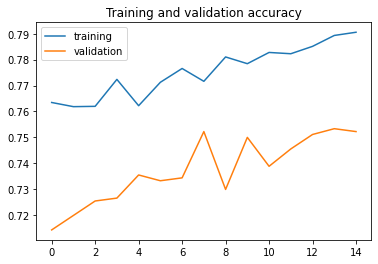

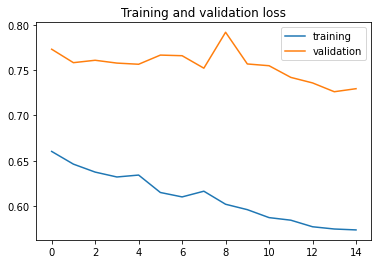

In [45]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')

**CONCLUSION** : According to the above plots, one can see that the training set accuracy is higher than the validation set accuracy while it is vice versa for their respective losses.

As well as it was noticed that the test set accuracy was lower than both the training set accuracy as well as the validation set accuracy.

Fine tuning the model increased the accuracy of the model from almost 73% to 79%.

**CONTRIBUTIONS** : 

Code by self ---- 50%

Code referred ---- 50%

**CITATIONS** :

SKIN CANCER MNIST DATASET KAGGLE: https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000

OVERVIEW OF IMAGE CLASSIFICATION USING CNN: https://analyticsindiamag.com/deep-learning-image-classification-with-cnn-an-overview/

IMAGE CLASSIFICATION USING MOBILENET MEDIUM: https://medium.com/analytics-vidhya/image-classification-using-mobilenet-in-the-browser-b69f2f57abf

**LICENSE**

Copyright 2019 Ria Rajput

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions: The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software. THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.